In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optimization
import evaluation
import strawberryfields as sf

/Users/etiennestock/Documents/packages/strawberryfields/strawberryfields/apps/data/sample.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# general stuff
state_dict = {(0, 0): '0', (np.pi, 0): '1', (np.pi/2, 0): '+'} # dictionary to save the date properly
def Vtanhgate(s): return sf.ops.Vgate(np.tanh(s))
def Kdl2c2gate(kappa): return sf.ops.Kdlcgate(kappa, 2, 2)
def Kdl6c2gate(kappa): return sf.ops.Kdlcgate(kappa, 6, 2)
def Kdl10c2gate(kappa): return sf.ops.Kdlcgate(kappa, 10, 2)

In [3]:
# read in and store data
file_names = ['data_0_XRKd2S_60_025_15', 'data_0_XRKd6S_60_025_15', 'data_0_XRKd10S_60_025_15']
lam        = [2, 6, 10]


# read in models
num_blocks = []
num_trials = []
opt        = np.empty(len(file_names), dtype=optimization.Optimization)
for i in range(len(file_names)): 
    opt[i]      = optimization.Optimization(file_name=file_names[i])
    num_blocks.append(opt[i].get_num_blocks())
    num_trials.append(opt[i].get_num_trials())


# check consistency
delta = opt[0].get_delta()
if not all([delta == opt[i].get_delta() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different deltas!')

epsilon = opt[0].get_epsilon()
if not all([epsilon == opt[i].get_epsilon() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different epsilons!')

cutoff = opt[0].get_cutoff()
if not all([cutoff == opt[i].get_cutoff() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different cutoffs!')
    
state = opt[0].get_state()
if not all([state == opt[i].get_state() for i in range(1, len(file_names))]):
    raise ValueError('Try to compare data with different states!')
    

# read in data of models
bestSols  = []
bestFids  = []
circuits  = []
# gates    = []
gates     = [
    np.array([sf.ops.Xgate, sf.ops.Rgate, Kdl2c2gate , sf.ops.Sgate]),
    np.array([sf.ops.Xgate, sf.ops.Rgate, Kdl6c2gate, sf.ops.Sgate]),
    np.array([sf.ops.Xgate, sf.ops.Rgate, Kdl10c2gate, sf.ops.Sgate]),
]
rev_gates = []

for i in range(len(file_names)):
    bestSols.append(opt[i].get_bestSol())
    bestFids.append(opt[i].get_bestFid())
    circuits.append(opt[i].get_circuit())
    # gates.append(opt[i].get_gates())
    rev_gates.append(np.flip(gates[i]))


# read into pandas results 
results = pd.DataFrame(data=np.array([circuits] + list([bestFids])).T, columns=['method'] + [r'$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$'])


In [4]:
# reconstruct the state with the Kerr-Cubic approximation
num_gates = len(gates[0])
if not all([num_gates == len(gate) for gate in gates]):
    raise ValueError('Try to use data with different number of gate sets!')

num_block = num_blocks[0]
if not all([num_block == n for n in num_blocks]):
    raise ValueError('Try to use data with different number of blocks!')

s = np.ones((3, num_block, num_gates))
s[:,:,1] = (3 * np.sqrt(2)*np.array(lam)**6)[:, None]

params_rec_rev = (- s * np.flip(np.array(bestSols), axis=1).reshape(3, num_block, num_gates)).reshape(3, -1)
gates_rec_rev  = [
    np.array([sf.ops.Sgate, sf.ops.Vgate, sf.ops.Rgate, sf.ops.Xgate]),
    np.array([sf.ops.Sgate, sf.ops.Vgate, sf.ops.Rgate, sf.ops.Xgate]),
    np.array([sf.ops.Sgate, sf.ops.Vgate, sf.ops.Rgate, sf.ops.Xgate]),
]

In [5]:
# Prepare the target state in Fock basis, so that we can compare with our generated state
target_GKP = evaluation.prepare_GKP(epsilon=epsilon, cutoff=cutoff, state=state).ket()

generated_GKP = []
rec_GKP       = []
normgen       = []
normgen_rec   = []
fid           = []
fid_rec       = []
fid_gen_rec   = []

for i in range(len(circuits)):    
    generated_GKP.append(evaluation.prepare_state(rev_gates[i], -np.flip(opt[i].get_bestSol()), cutoff).ket())
    normgen.append(np.dot(generated_GKP[i].conj(), generated_GKP[i]))
    fid.append(np.abs(np.dot(generated_GKP[i].conj(), target_GKP))**2)

    rec_GKP.append(evaluation.prepare_state(gates_rec_rev[i], params_rec_rev[i], cutoff).ket())
    normgen_rec.append(np.dot(rec_GKP[i].conj(), rec_GKP[i]))
    fid_rec.append(np.abs(np.dot(rec_GKP[i].conj(), target_GKP))**2)

    fid_gen_rec.append(np.abs(np.dot(rec_GKP[i].conj(), generated_GKP[i]))**2)


# Add results
results[r'$|\langle\Psi_g|\Psi_g\rangle|^2$'] = normgen
results[r'$|\langle\Psi_g|\Psi_t\rangle|^2$'] = fid

results[r'$|\langle\Psi_{\text{rec}}|\Psi_{\text{rec}}\rangle|^2$'] = normgen_rec
results[r'$|\langle\Psi_{\text{rec}}|\Psi_t\rangle|^2$'] = fid_rec

results[r'$|\langle\Psi_{\text{rec}}|\Psi_{g}\rangle|^2$'] = fid_gen_rec


# # calculate Glancy-Knill error
# n    = 30 # Number of strips in integration
# size = 30 # Infinite sums over  s and t are truncated to go from -size to +size

# results[r'$P_{\text{error}}$'] = np.empty(len(circuits), dtype=np.float32)
# results[r'$P_{\text{error}, \text{rec}}$'] = np.empty(len(circuits), dtype=np.float32)

# for i in range(len(circuits)): 
#     results.loc[i, r'$P_{\text{error}}$'] = evaluation.error_gancy_knill(generated_GKP[i], n, size)
#     results.loc[i, r'$P_{\text{error}, \text{rec}}$'] = evaluation.error_gancy_knill(rec_GKP[i], n, size)

In [6]:
results

,method,$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,$|\langle\Psi_g|\Psi_g\rangle|^2$,$|\langle\Psi_g|\Psi_t\rangle|^2$,$|\langle\Psi_{\text{rec}}|\Psi_{\text{rec}}\rangle|^2$,$|\langle\Psi_{\text{rec}}|\Psi_t\rangle|^2$,$|\langle\Psi_{\text{rec}}|\Psi_{t}\rangle|^2$
0,XRKd2S,0.8951580976609915,0.960419+0.000000j,0.895158,0.889810+0.000000j,0.030240,0.035098
1,XRKd6S,0.1043883736475632,0.919074+0.000000j,0.104388,0.938286+0.000000j,0.010338,0.024459
2,XRKd10S,0.12218878040951553,0.923756+0.000000j,0.122189,0.951280+0.000000j,0.015137,0.023260


In [7]:
# Plot probability distribution of generated, reconconstructed target GKP states
qnum    = 8
qlim    = qnum*np.sqrt(np.pi) # q-axis goes from -qlim to +qlim
qvalues = np.linspace(-qlim,qlim, 1000)

targetGKPwf = evaluation.wavefunction(q=qvalues, ket=target_GKP)
gauss       = lambda x: np.max(np.abs(targetGKPwf*targetGKPwf.conj())) * np.exp(-x**2*(delta)**2)

genGKPwf = []
recGKPwf = []
for i in range(len(circuits)):
    genGKPwf.append(evaluation.wavefunction(q=qvalues, ket=generated_GKP[i]))
    recGKPwf.append(evaluation.wavefunction(q=qvalues, ket=rec_GKP[i]))

<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_36316/1844709657.py:10: SyntaxWarning: invalid escape sequence '\P'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_36316/1844709657.py:12: SyntaxWarning: invalid escape sequence '\s'


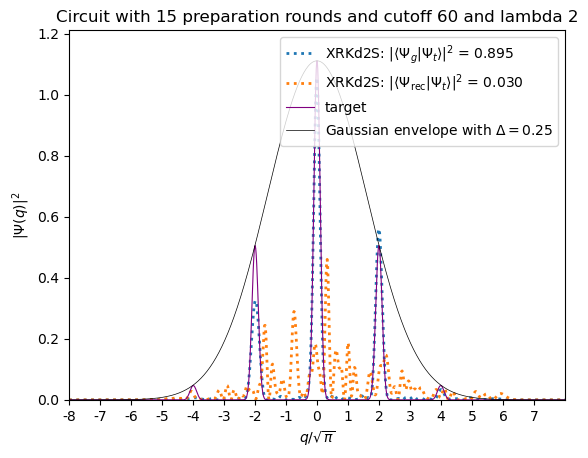

In [8]:
# plot to compare for lambda = 2
i = 0

plt.plot(qvalues, np.abs(genGKPwf[i]*genGKPwf[i].conj()), label=f'{circuits[i]}: '+r'$|\langle\Psi_g|\Psi_t\rangle|^2$'+f' = {fid[i]:.3f}', linestyle='dotted', linewidth=2)
plt.plot(qvalues, np.abs(recGKPwf[i]*recGKPwf[i].conj()), label=f'{circuits[i]}: '+r'$|\langle\Psi_\text{rec}|\Psi_t\rangle|^2$'+f' = {fid_rec[i]:.3f}', linestyle='dotted', linewidth=2)

plt.plot(qvalues, np.abs(targetGKPwf*targetGKPwf.conj()), label='target', color='purple', linewidth=0.8)
plt.plot(qvalues, gauss(qvalues), label=r'Gaussian envelope with $\Delta =$'+f'{delta}', color='black', linewidth=0.5)

plt.ylabel("$|\Psi(q)|^2$")
plt.xticks(np.sqrt(np.pi)*np.arange(-qnum, qnum), np.arange(-qnum, qnum))
plt.xlabel("$q/\sqrt{\pi}$")
plt.xlim(np.min(qvalues), np.max(qvalues))
plt.ylim(0, np.max(np.abs(targetGKPwf*targetGKPwf.conj()))+0.1)
plt.title(f'Circuit with {np.max(num_blocks)} preparation rounds and cutoff {cutoff} and lambda {lam[i]}')
plt.legend(loc='upper right')

# plt.savefig(f'plots/plot_{cutoff}_{str(delta).replace(".", "")}_{np.max(num_blocks)}_' + '_'.join(str(c) for c in circuits) + '.png')
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_36316/980373336.py:10: SyntaxWarning: invalid escape sequence '\P'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_36316/980373336.py:12: SyntaxWarning: invalid escape sequence '\s'


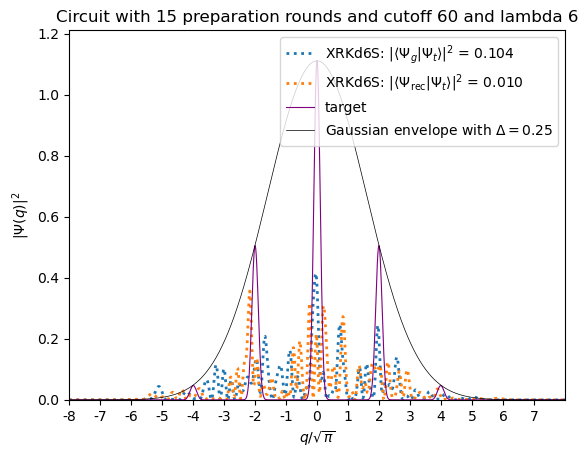

In [9]:
# plot to compare for lambda = 6
i = 1

plt.plot(qvalues, np.abs(genGKPwf[i]*genGKPwf[i].conj()), label=f'{circuits[i]}: '+r'$|\langle\Psi_g|\Psi_t\rangle|^2$'+f' = {fid[i]:.3f}', linestyle='dotted', linewidth=2)
plt.plot(qvalues, np.abs(recGKPwf[i]*recGKPwf[i].conj()), label=f'{circuits[i]}: '+r'$|\langle\Psi_\text{rec}|\Psi_t\rangle|^2$'+f' = {fid_rec[i]:.3f}', linestyle='dotted', linewidth=2)

plt.plot(qvalues, np.abs(targetGKPwf*targetGKPwf.conj()), label='target', color='purple', linewidth=0.8)
plt.plot(qvalues, gauss(qvalues), label=r'Gaussian envelope with $\Delta =$'+f'{delta}', color='black', linewidth=0.5)

plt.ylabel("$|\Psi(q)|^2$")
plt.xticks(np.sqrt(np.pi)*np.arange(-qnum, qnum), np.arange(-qnum, qnum))
plt.xlabel("$q/\sqrt{\pi}$")
plt.xlim(np.min(qvalues), np.max(qvalues))
plt.ylim(0, np.max(np.abs(targetGKPwf*targetGKPwf.conj()))+0.1)
plt.title(f'Circuit with {np.max(num_blocks)} preparation rounds and cutoff {cutoff} and lambda {lam[i]}')
plt.legend(loc='upper right')

# plt.savefig(f'plots/plot_{cutoff}_{str(delta).replace(".", "")}_{np.max(num_blocks)}_' + '_'.join(str(c) for c in circuits) + '.png')
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_36316/2385702874.py:10: SyntaxWarning: invalid escape sequence '\P'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_36316/2385702874.py:12: SyntaxWarning: invalid escape sequence '\s'


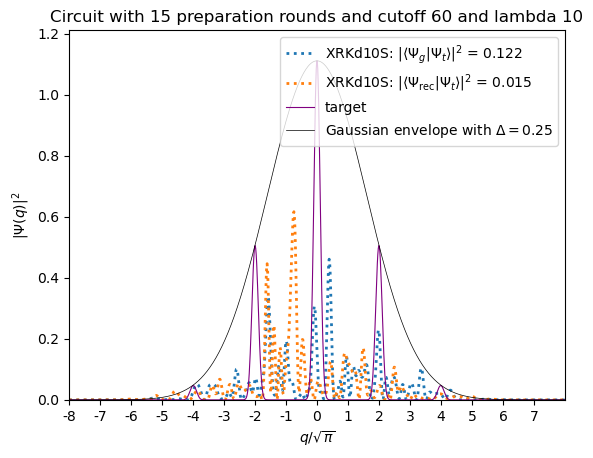

In [10]:
# plot to compare for lambda = 6
i = 2

plt.plot(qvalues, np.abs(genGKPwf[i]*genGKPwf[i].conj()), label=f'{circuits[i]}: '+r'$|\langle\Psi_g|\Psi_t\rangle|^2$'+f' = {fid[i]:.3f}', linestyle='dotted', linewidth=2)
plt.plot(qvalues, np.abs(recGKPwf[i]*recGKPwf[i].conj()), label=f'{circuits[i]}: '+r'$|\langle\Psi_\text{rec}|\Psi_t\rangle|^2$'+f' = {fid_rec[i]:.3f}', linestyle='dotted', linewidth=2)

plt.plot(qvalues, np.abs(targetGKPwf*targetGKPwf.conj()), label='target', color='purple', linewidth=0.8)
plt.plot(qvalues, gauss(qvalues), label=r'Gaussian envelope with $\Delta =$'+f'{delta}', color='black', linewidth=0.5)

plt.ylabel("$|\Psi(q)|^2$")
plt.xticks(np.sqrt(np.pi)*np.arange(-qnum, qnum), np.arange(-qnum, qnum))
plt.xlabel("$q/\sqrt{\pi}$")
plt.xlim(np.min(qvalues), np.max(qvalues))
plt.ylim(0, np.max(np.abs(targetGKPwf*targetGKPwf.conj()))+0.1)
plt.title(f'Circuit with {np.max(num_blocks)} preparation rounds and cutoff {cutoff} and lambda {lam[i]}')
plt.legend(loc='upper right')

# plt.savefig(f'plots/plot_{cutoff}_{str(delta).replace(".", "")}_{np.max(num_blocks)}_' + '_'.join(str(c) for c in circuits) + '.png')
plt.show()